# Introduction

If you've delved into lattice-based cryptography, you've probably encountered the intriguing concept of the smoothing parameter. In this post, we'll break it down step by step, "reverse engineering" this essential lattice parameter. The aim? To help you develop a clear and intuitive understanding of it—rooted in solid mathematical principles (and maybe a touch of fun)! 😊

One of the standout features of lattice-based cryptography is its robust worst-case to average-case reduction security proof. Here's the essence: when we set up a lattice-based cryptosystem, elements like secret keys and noise are generated randomly. If we assume an attacker cannot solve the underlying mathematical problem for a random instance, the system is said to have average-case security. But lattice-based cryptography takes this a step further. It provides rigorous proofs showing that solving a random (average-case) instance of certain lattice problems is at least as hard as solving the worst-case instance of a related problem. In simpler terms, if an attacker can break a random instance, they can also crack the hardest instances. This foundational property greatly boosts our confidence in the security of lattice-based cryptography.

Let’s begin with the big picture: many security proofs in the lattice world rely on the following structure:

1. Choose a lattice point.  
2. Randomly generate a noise vector.  
3. Add the noise to the lattice point and reduce the result modulo the fundamental domain.  

To make this more concrete, consider an example in $\mathbb{R}^2$. Here, the chosen lattice point is represented by the green point, the noise by the red vector, the sum of the two by the blue point, and the reduction modulo the fundamental domain (the hashed area) by the 'x' point.

For clarity and completeness, let’s introduce some notations:

1. $L$ represents the lattice.  
2. $B \in \mathbb{R}^{n \times n}$ is the basis of the lattice $L$.  
3. $\mathcal{P}(B)$ denotes the fundamental domain of the lattice.  

This structure forms the foundation for understanding key concepts in lattice-based cryptography.

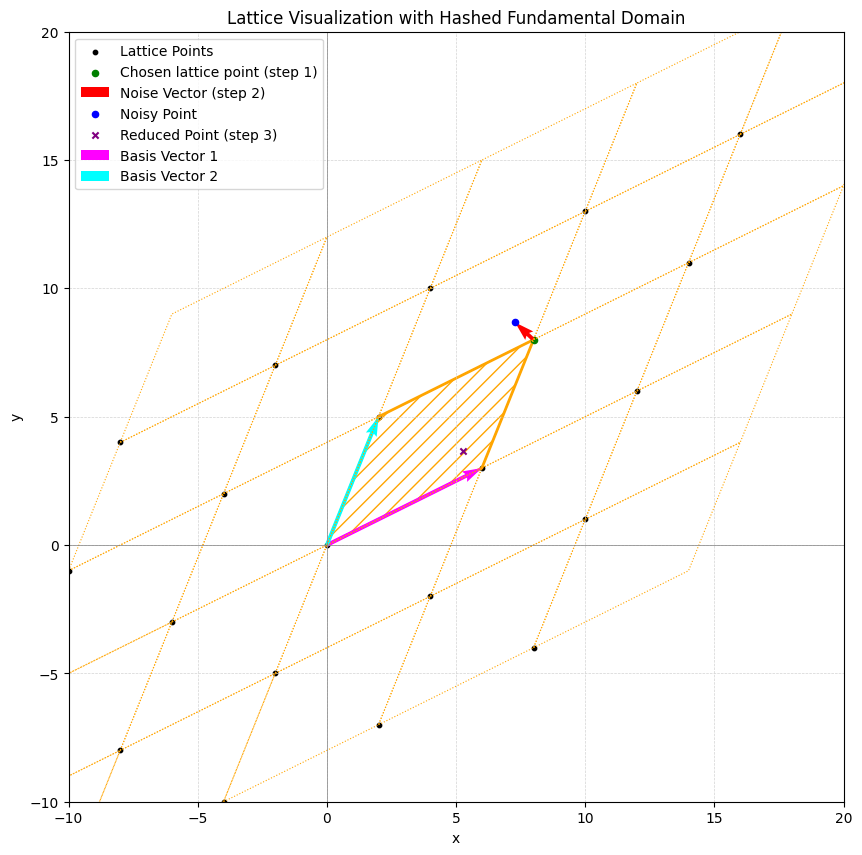

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Function to generate lattice points
def generate_lattice(basis, x_range, y_range):
    points = []
    for i in range(x_range[0], x_range[1]):
        for j in range(y_range[0], y_range[1]):
            point = i * basis[:, 0] + j * basis[:, 1]
            points.append(point)
    return np.array(points)

# Function to reduce a point modulo the fundamental domain
def reduce_mod_basis(point, basis):
    inv_basis = np.linalg.inv(basis)
    coeffs = np.dot(inv_basis, point)
    coeffs = coeffs - np.floor(coeffs) # Reduce coefficients mod 1
    return np.dot(basis, coeffs)

# Define the lattice basis (2D) with larger vectors
basis = np.array([[6, 2], [3, 5]])

# Generate lattice points
lattice_points = generate_lattice(basis, x_range=(-2, 3), y_range=(-2, 3))

# Select a lattice point (green dot)
lattice_point = 1 * basis[:, 0] + 1 * basis[:, 1] # Example: (1, 1) in lattice coordinates

# Add noise (larger random vector)
noise = np.random.uniform(-5, 5, size=2) # Larger noise
noisy_point = lattice_point + noise

# Reduce modulo the fundamental domain
reduced_point = reduce_mod_basis(noisy_point, basis)

# Plot the lattice
plt.figure(figsize=(10, 10))
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='black', s=10, label='Lattice Points')

# Plot all parallelograms in the lattice
for point in lattice_points:
    parallelogram = np.array([
        point,
        point + basis[:, 0],
        point + basis[:, 0] + basis[:, 1],
        point + basis[:, 1],
        point
    ])
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], color='orange', linestyle='dotted', linewidth=0.8)

# Highlight the fundamental domain (parallelogram at the origin) with a hashed pattern
fundamental_parallelogram = np.array([
    [0, 0],
    basis[:, 0],
    basis[:, 0] + basis[:, 1],
    basis[:, 1],
    [0, 0]
])
polygon = Polygon(fundamental_parallelogram, closed=True, facecolor='none', edgecolor='orange', hatch='//', linewidth=2)
plt.gca().add_patch(polygon)

# Plot the lattice point (green dot)
plt.scatter(lattice_point[0], lattice_point[1], color='green', s=20, label='Chosen lattice point (step 1)')

# Plot the noise vector (larger arrow)
plt.quiver(
    lattice_point[0], lattice_point[1], noise[0], noise[1],
    angles='xy', scale_units='xy', scale=1, color='red', width=0.005, label='Noise Vector (step 2)'
)

# Plot the noisy point
plt.scatter(noisy_point[0], noisy_point[1], color='blue', s=20, label='Noisy Point')

# Plot the reduced point
plt.scatter(reduced_point[0], reduced_point[1], color='purple', s=20, marker='x', label='Reduced Point (step 3)')

# Mark the basis vectors
plt.quiver(
    0, 0, basis[0, 0], basis[1, 0],
    angles='xy', scale_units='xy', scale=1, color='magenta', width=0.005, label='Basis Vector 1'
)
plt.quiver(
    0, 0, basis[0, 1], basis[1, 1],
    angles='xy', scale_units='xy', scale=1, color='cyan', width=0.005, label='Basis Vector 2'
)

# Add labels and legend
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Lattice Visualization with Hashed Fundamental Domain')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Zoom in on a smaller region of the lattice
plt.axis('auto')
plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()


# The problem 

Now, let’s introduce some constraints:

1. We want the expected norm of the error vector to be a specific value, denoted as $s$.  
2. As with most things in cryptography, we want the result of the reduction to appear as if it were sampled from a uniform distribution.  

Why do we need these properties? Well, that’s a story for another article! 😊  

At first glance, one might think: "If we want vectors that look uniformly distributed, why not just sample each coordinate from a uniform distribution?" While this approach works perfectly for the second property, it fails to satisfy the first. Sampling each coordinate uniformly results in vectors with norms that deviate significantly from the desired value $s$.  

To focus on the first property, one solution is to sample each coordinate from a Gaussian distribution with a standard deviation of $s / \sqrt{n}$, where $n$ is the number of coordinates. This ensures the expected norm of the vector is $s$. But what about the "uniform-like" appearance?  

Let’s build some intuition. A lattice has a clear periodic structure. Looking at the earlier example, we see the fundamental domain (a single cell) repeating endlessly to cover the entire space. This means any point in space can be expressed as the sum of a point in the fundamental domain and a lattice point.  

From another perspective, if we repeatedly translate the fundamental domain by lattice points, we cover the entire space. Thus, every point can be uniquely written as the sum of a lattice point and a point within the fundamental domain. This is illustrated in the figure below and can be expressed formally as:  

$$ w = t + v, \text{ for a unique } t \in \mathcal{P}(B) \text{ and a unique } v \in L. $$  

This decomposition is key to understanding how we achieve both properties simultaneously.

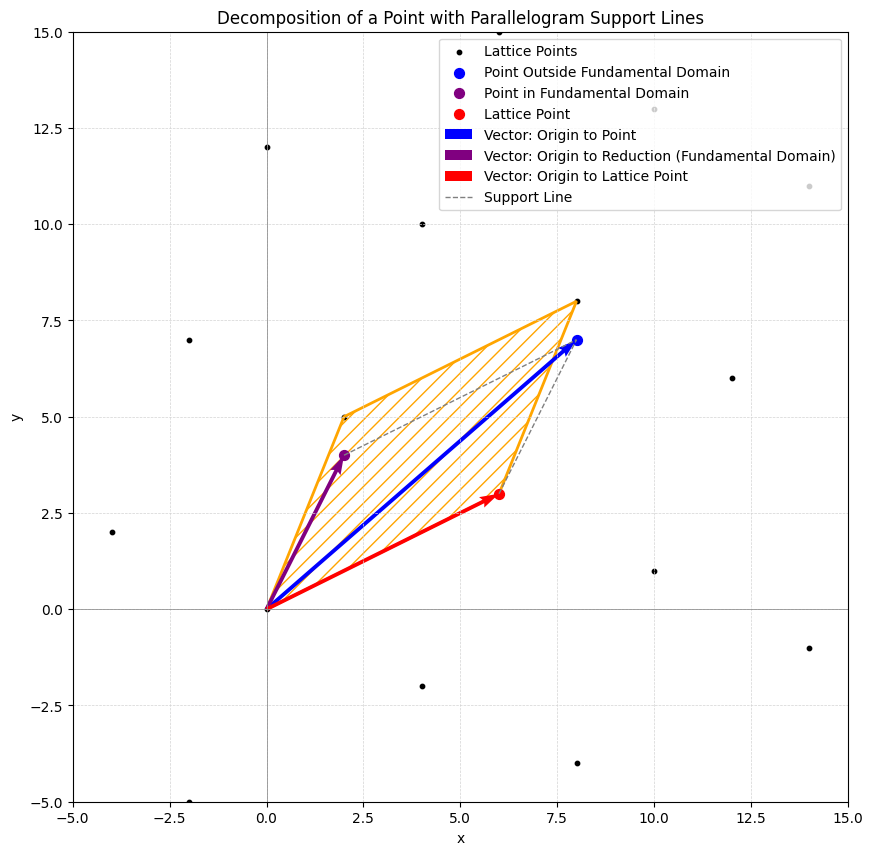

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Function to generate lattice points
def generate_lattice(basis, x_range, y_range):
    points = []
    for i in range(x_range[0], x_range[1]):
        for j in range(y_range[0], y_range[1]):
            point = i * basis[:, 0] + j * basis[:, 1]
            points.append(point)
    return np.array(points)

# Function to reduce a point modulo the fundamental domain
def reduce_mod_basis(point, basis):
    inv_basis = np.linalg.inv(basis)
    coeffs = np.dot(inv_basis, point)
    lattice_point = np.dot(basis, np.floor(coeffs))  # Lattice point
    fundamental_point = point - lattice_point       # Point in the fundamental domain
    return fundamental_point, lattice_point

# Define the lattice basis (2D)
basis = np.array([[6, 2], [3, 5]])

# Generate lattice points
lattice_points = generate_lattice(basis, x_range=(-3, 4), y_range=(-3, 4))

# Define a point closer to the origin
outside_point = np.array([8, 7])  # Example point closer to the origin

# Decompose the point into a fundamental domain point and a lattice point
fundamental_point, lattice_point = reduce_mod_basis(outside_point, basis)

# Plot the lattice
plt.figure(figsize=(10, 10))
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='black', s=10, label='Lattice Points')

# Highlight the fundamental domain (parallelogram at the origin)
fundamental_parallelogram = np.array([
    [0, 0],
    basis[:, 0],
    basis[:, 0] + basis[:, 1],
    basis[:, 1],
    [0, 0]
])
polygon = Polygon(fundamental_parallelogram, closed=True, facecolor='none', edgecolor='orange', hatch='//', linewidth=2)
plt.gca().add_patch(polygon)

# Plot the point outside the fundamental domain
plt.scatter(outside_point[0], outside_point[1], color='blue', s=50, label='Point Outside Fundamental Domain')

# Plot the fundamental domain point
plt.scatter(fundamental_point[0], fundamental_point[1], color='purple', s=50, label='Point in Fundamental Domain')

# Plot the lattice point
plt.scatter(lattice_point[0], lattice_point[1], color='red', s=50, label='Lattice Point')

# Draw vector from origin to the outside point
plt.quiver(
    0, 0,
    outside_point[0], outside_point[1],
    angles='xy', scale_units='xy', scale=1, color='blue', width=0.005, label='Vector: Origin to Point'
)

# Draw vector from origin to the fundamental domain point
plt.quiver(
    0, 0,
    fundamental_point[0], fundamental_point[1],
    angles='xy', scale_units='xy', scale=1, color='purple', width=0.005, label='Vector: Origin to Reduction (Fundamental Domain)'
)

# Draw vector from origin to the lattice point
plt.quiver(
    0, 0,
    lattice_point[0], lattice_point[1],
    angles='xy', scale_units='xy', scale=1, color='red', width=0.005, label='Vector: Origin to Lattice Point'
)

# Add support lines to form the parallelogram
# Line from lattice point to the outside point
plt.plot(
    [lattice_point[0], outside_point[0]],
    [lattice_point[1], outside_point[1]],
    color='gray', linestyle='--', linewidth=1, label='Support Line'
)

# Line from fundamental point to the outside point
plt.plot(
    [fundamental_point[0], outside_point[0]],
    [fundamental_point[1], outside_point[1]],
    color='gray', linestyle='--', linewidth=1
)

# Add labels and legend
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Decomposition of a Point with Parallelogram Support Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Adjust zoom level for better visualization
plt.axis('auto')
plt.xlim(-5, 15)
plt.ylim(-5, 15)

plt.show()


# Gaussian reduction
This equivalence relation naturally emerges: two points are considered equivalent if they map to the same point in the fundamental domain. In other words, two points are equivalent if they differ by a lattice vector.

Now, let’s revisit the Gaussian distribution, denoted by $\mathcal{G}_s$, which describes the probability distribution of vectors with an expected norm $s$. For each point $x \in \mathbb{R}^n$, $\mathcal{G}_s$ assigns a probability density value $\mathcal{G}_s(x)$. 

This leads to an intriguing question:

**How does the Gaussian distribution behave under the equivalence relation?**  
**What is the density value assigned to a point in the fundamental domain?**

Recall that for every point $t \in \mathcal{P}(B)$ (the fundamental domain), there are infinitely many equivalent points in $\mathbb{R}^n$ that differ by lattice vectors. For instance, $\mathcal{G}_s$ assigns a density value to $t$ and another density value to each equivalent point $w = t + v$, where $v$ is any lattice vector. However, under the equivalence relation, all these points $w$ are treated as "the same" as $t$. So, how do we assign a single density value to $t$?

A natural solution is to define a new probability distribution, $\mathcal{D}_s$, restricted to the fundamental domain. The density value assigned by $\mathcal{D}_s$ to a point $t \in \mathcal{P}(B)$ is the sum of all density values assigned by $\mathcal{G}_s$ to its equivalent points $w = t + v$, for all $v \in L$. Formally, this is written as:

$$ \mathcal{D}_s(x) = \sum_{z \in L} \mathcal{G}_s(x + z) $$

This construction ensures that $\mathcal{D}_s$ respects the equivalence relation and is properly defined over the fundamental domain.

Let’s take another look at our goal. We want to sample an error vector from a Gaussian distribution with an expected norm of $s$. However, after reducing this error to the fundamental domain, it should appear as though it was sampled from a uniform distribution. In other words, while the error is initially drawn from $\mathcal{G}_s$, we want the resulting distribution $\mathcal{D}_s$ to be indistinguishable from a uniform distribution.

To build intuition, let’s consider a simple lattice, $\mathbb{Z}$, with the fundamental domain $[0, 1)$. We’ll explore how $\mathcal{D}_s$ behaves for different values of $s$. For small values of $s$ (e.g., $0.1$, $0.2$), $\mathcal{D}_s$ is far from uniform—it has noticeable peaks and valleys, unlike the flat line of a uniform distribution. But as $s$ increases, something fascinating happens: $\mathcal{D}_s$ starts to flatten out, gradually resembling a uniform distribution. For sufficiently large $s$, $\mathcal{D}_s$ becomes nearly indistinguishable from uniform.

This behavior is key to achieving both properties: maintaining the expected norm of $s$ while ensuring the reduced error appears uniform.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Gaussian function G_s
def G_s(x, s):
    scale = np.sqrt(2 * np.pi) * s
    return (1 / scale) * np.exp(-np.pi * (x / scale) ** 2)

# Periodic sum D_s over the integer lattice
def D_s(x, s, num_terms=100):
    return sum(G_s(x - z, s) for z in range(-num_terms, num_terms + 1))

# Plotting function for interactive slider
def plot_Gs_Ds(s):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Plot G_s over the real line
    x1 = np.linspace(-4, 4, 1000)
    axs[0].plot(x1, G_s(x1, s), label=f'$G_s$, s={s:.2f}')
    axs[0].set_title("$G_s(x)$ over $\mathbb{R}$")
    axs[0].set_ylabel("$G_s(x)$")
    axs[0].legend()
    axs[0].grid(True)

    # Plot D_s over extended domain to show multiple periods
    x2 = np.linspace(0, 1, 1500)
    y2 = [D_s(val, s) for val in x2]
    axs[1].plot(x2, y2, label=f'$D_s$, s={s:.2f}')
    axs[1].set_title("$D_s(x)$ over $[0, 1]$")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("$D_s(x)$")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Interactive slider for s
interact(plot_Gs_Ds, s=FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description='s'));


interactive(children=(FloatSlider(value=0.2, description='s', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

To summarize the big picture: our goal is to sample error vectors from a Gaussian distribution to achieve an expected norm of $s$, while ensuring that the error appears uniformly distributed when reduced modulo the fundamental domain. The intuitive way to meet both requirements is to make the Gaussian distribution sufficiently wide.

This makes sense intuitively: a Gaussian distribution is defined by its characteristic "hump." When the distribution is wide enough and mapped into a small cell (the fundamental domain), the "hump" effect diminishes, producing a distribution that closely resembles uniformity.

Now, we still have one crucial question to address: how "wide" does the Gaussian distribution need to be for $\mathcal{D}_s$ to appear uniform? To answer this, we need a way to measure how "uniform" $\mathcal{D}_s$ actually is. Here’s a hint: let’s visualize $\mathcal{D}_s$ by plotting it over the entire space. This will give us valuable insights into its behavior and help us determine the required "width."

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Gaussian function G_s
def G_s(x, s):
    scale = np.sqrt(2 * np.pi) * s
    return (1 / scale) * np.exp(-np.pi * (x / scale) ** 2)

# Periodic sum D_s over the integer lattice
def D_s(x, s, num_terms=100):
    return sum(G_s(x - z, s) for z in range(-num_terms, num_terms + 1))

# Plotting function for interactive slider
def plot_Gs_Ds(s):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Plot G_s over the real line
    x1 = np.linspace(-4, 4, 1000)
    axs[0].plot(x1, G_s(x1, s), label=f'$G_s$, s={s:.2f}')
    axs[0].set_title("$G_s(x)$ over $\mathbb{R}$")
    axs[0].set_ylabel("$G_s(x)$")
    axs[0].legend()
    axs[0].grid(True)

    # Plot D_s over extended domain to show multiple periods
    x2 = np.linspace(-3, 3, 1500)
    y2 = [D_s(val, s) for val in x2]
    axs[1].plot(x2, y2, label=f'$D_s$, s={s:.2f}')
    axs[1].set_title("$D_s(x)$ over $[-3, 3]$")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("$D_s(x)$")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Interactive slider for s
interact(plot_Gs_Ds, s=FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description='s'));


interactive(children=(FloatSlider(value=0.2, description='s', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

# Fourier 
It looks a lot like a periodic function, doesn’t it? This observation doesn’t change what we’ve noted about $s$: as $s$ increases, $\mathcal{D}_s$ becomes increasingly uniform.

This periodicity naturally leads us to think about Fourier analysis.  

Consider a "nice" periodic function $f: \mathcal{P}(B) \rightarrow \mathbb{R}$. Why $\mathcal{P}(B)$ and not $\mathbb{R}^n$? Well, since the function is periodic over the lattice, it’s sufficient to define it over a single lattice cell (the fundamental domain). Fourier transform allows us to express $f$ as a sum of periodic basis functions of the form $x \mapsto e^{2\pi i \langle x, y \rangle}$.  

Let’s visualize some of these basis functions—or at least the real part of them—to build intuition!

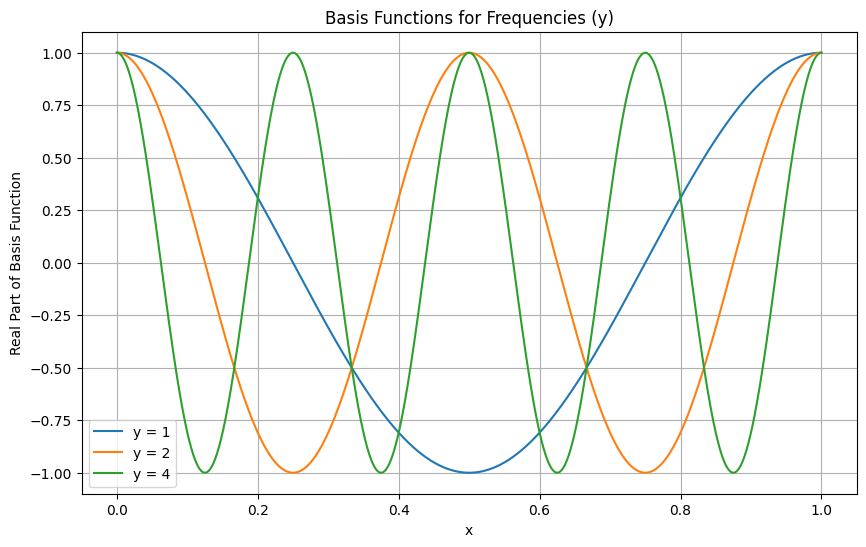

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
x = np.linspace(0, 1, 1000)  # x values from 0 to 1
y_values = [1, 2, 4]  # Different y values

# Plot basis functions
plt.figure(figsize=(10, 6))
for y in y_values:
    basis_function = np.exp(2j * np.pi * y * x)  # Complex exponential
    plt.plot(x, np.real(basis_function), label=f'y = {y}')  # Plot real part

# Customize the plot
plt.title('Basis Functions for Frequencies (y)')
plt.xlabel('x')
plt.ylabel('Real Part of Basis Function')
plt.legend()
plt.grid()
plt.show()


We’ve plotted some basis functions for $y = 1$, $y = 2$, and $y = 4$, but why not try $y = \sqrt{2}$ or $y = 1.5$? What determines the allowed values for the frequencies? The answer lies in the periodicity of the basis functions:  

$$ e^{2\pi i \langle x, y \rangle} = e^{2\pi i \langle x+v, y \rangle}, \quad \text{for all } v \in L. $$  

Expanding this, we get:  

$$ e^{2\pi i \langle x+v, y \rangle} = e^{2\pi i \langle x, y \rangle} e^{2\pi i \langle v, y \rangle}, $$  

which implies:  

$$ e^{2\pi i \langle v, y \rangle} = 1. $$  

This condition holds when $2\pi i \langle v, y \rangle = 0$, or equivalently, when $\langle v, y \rangle \in \mathbb{Z}$ for all $v \in L$.  

In other words, the allowed frequencies are vectors $y \in \mathbb{R}^n$ such that their dot product with every point in the lattice $L$ is an integer. Interestingly, these frequencies themselves form a lattice, called the **dual lattice**, denoted by $L^*$.

Let’s return to our function $f$, which can be expressed as:

$$ f(x) = \sum_{y \in L^*} \hat{f}(y) e^{2\pi i \langle x, y \rangle}, $$

where the Fourier coefficients $\hat{f}(y)$ are given by:

$$ \hat{f}(y) = \frac{1}{\det(L)} \int_{\mathcal{P}(B)} f(x) e^{-2\pi i \langle x, y \rangle} \, dx. $$

Here, $\hat{f}(y)$ represents the "weight" of the basis function $e^{2\pi i \langle x, y \rangle}$ in the decomposition. While this may seem abstract, in our case, $f$ is simply the Gaussian distribution $\mathcal{D}_s(x)$, which represents the reduced Gaussian over the fundamental domain. For this specific function, the Fourier coefficients are straightforward to compute. Ignoring the constant $\det(L)$ for simplicity, we have:

$$ \hat{\mathcal{D}}_s(y) = e^{-\pi s^2 |y|^2}. $$

Why does this matter? Our goal is to measure how "uniform" $\mathcal{D}_s$ is. Intuitively, if $\mathcal{D}_s$ were perfectly uniform, its Fourier transform would have only one non-zero coefficient at $y = 0$, with $\hat{\mathcal{D}}_s(0) = 1$. All other coefficients would be zero, as a uniform distribution requires no additional frequencies to describe it.

In general, we can define a "uniformity metric" for $\mathcal{D}_s$ by summing the Fourier coefficients for all non-zero frequencies. The smaller this sum, the closer $\mathcal{D}_s$ is to uniform. This metric is expressed as:

$$ \rho_{1/s}(L^* \setminus \{0\}) = \sum_{y \in L^* \setminus \{0\}} e^{-\pi |y|^2 s^2}. $$

This notation aligns with standard conventions, where $\rho$ represents the Gaussian mass. The goal in applications is to ensure that $\mathcal{D}_s$ is sufficiently uniform by keeping this metric below a chosen threshold $\epsilon$:

$$ \rho_{1/s}(L^* \setminus \{0\}) < \epsilon. $$

While perfect uniformity is unattainable, this approach provides a practical and rigorous way to ensure $\mathcal{D}_s$ is "uniform enough" for cryptographic security.

# Conclusions

Let’s circle back to our motivation: we aimed to sample an error vector with a specific norm that appears uniformly distributed when reduced modulo the fundamental domain. The solution? Sample the vector from a Gaussian distribution $\mathcal{G}_s$ and reduce it to the fundamental domain. We observed that as the standard deviation $s$ increases, the reduced distribution becomes more uniform. To measure this uniformity, we introduced the metric $\rho_{1/s}(L^* \setminus \{0\})$.

Now, for the final piece: the **smoothing parameter** of a lattice, denoted by $\eta_{\epsilon}(L)$, is defined as the smallest $s$ such that:

$$ \rho_{1/s}(L^* \setminus \{0\}) < \epsilon. $$

In this article, we’ve developed some intuition around the smoothing parameter. But the real magic lies in how Regev used this concept in one of the most groundbreaking security reductions in lattice-based cryptography. Here’s a teaser: it connects to the shortest vector problem on the dual lattice. Curious? Stay tuned for the next chapter of this fascinating journey!

<sub><i>Disclaimer: This python code was generated by GenAI.</i></sub>

<sub><i>Complete notebook: https://github.com/miiip/crypto-notes/blob/main/Gaussian.ipynb</i></sub>




# Resources 

[Lattices Part II — Dual Lattices, Fourier Transform, Smoothing Parameter, Public Key Encryption](https://www.cs.princeton.edu/courses/archive/spr08/cos598D/lattices.pdf)

[Worst-case to Average-case Reductions based on Gaussian Measures](https://cims.nyu.edu/~regev/papers/average.pdf)